## Ensemble

In [ ]:
Voting - 서로 다른 모델 여러 개, 학습 데이터는 동일
         여러 모델의 결과를 집계 (hard voting - 개수, soft voting - 확률값의 평균)
         모델별로 가중치(weight)를 사용해서 서로 다른 권리를 부여할 수 있다

Bagging - 같은 모델 여러 개, 학습 데이터가 다름
          데이터 셋에서 - 일부 데이터를 sampling해서 학습데이터로 사용함
          데이터를 sampling을 부트스트랩(bootstrap)방식으로 함
           - 단순 임의 복원 추출 방식(중복 선택, 선택되지 않을 수 있음)
          모델간 서로 영향을 주지 않는 sampling과 학습이 이루어짐
          결과를 집계해서 최종 결과를 산출
          
Boosting - 순차적 학습
           데이터 셋에서 데이터를 sampling할  때 이전 모델의 학습결과를 사용해서 sampling을 함
           학습결과가 좋지 않은 sample에 대해 다시 학습 대상으로 사용될 확률을 높임

Stacking - 여러 개의 서로 다른 모델이 데이터셋에 대해 학습을 하여 결과를 만들어냄
           학습 결과를 가지고 다시 학습하는 모델 - 최종결과를 만들어냄 

## 1.함수 생성

In [ ]:
# [1] get_classification_scores 함수 만들기
# accuracy, precision, recall, f1
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

def get_classification_scores(model, x_test, y_test):
    y_pred = model.predict(x_test)
    A = accuracy_score(y_test, y_pred)
    B = precision_score(y_test, y_pred)
    C = recall_score(y_test, y_pred)
    D = f1_score(y_test, y_pred)
    return [round(x, 4) for x in [A, B, C, D]]

In [ ]:
# [2] get_regression_scores 함수 만들기
# r2_score, mae, mse, msle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

def get_regression_scores(model, x_test, y_test):
    y_pred = model.predict(x_test)
    A = r2_score(y_test, y_pred)
    B = mae(y_test, y_pred)
    C = mse(y_test, y_pred)
    D = msle(y_test, y_pred)
    return [round(x, 4) for x in [A, B, C, D]]

In [ ]:
# [3] make_data 함수 만들기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

def make_data(data, kind='classification'):

    # 데이터를 X, y로 분리한다
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # 스케일링 처리
    X_scaled = StandardScaler().fit_transform(X)

    # train test 분리 (7.5:2.5), 층화추출, random_state=0
    stratify = y if kind=='classification' else None
    result = train_test_split(X_scaled,
                              y,
                              stratify=stratify,
                              random_state=0) 
    return result


In [ ]:
# [4] make_classification_model 함수 만들기
def make_classification_model(name, model, data):
    # data 분리
    x_train, x_test, y_train, y_test = data

    # 모델 학습  
    model.fit(x_train, y_train)

    # train_scores, test_score 구하기
    train_scores = get_classification_scores(model, x_train, y_train)
    test_scores = get_classification_scores(model, x_test, y_test)

    # DataFrame으로 만들어 x_test, y_test 와 함께 반환하기
    index = ['name', 'model',
             'accuracy1', 'precision1', 'recall1', 'f1_1',
             'accuracy2', 'precision2', 'recall2', 'f1_2']
    data = [name, model] + train_scores + test_scores
    return pd.Series(data, index=index).to_frame().T

In [ ]:
# [5] make_regression_model 함수 만들기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

def make_regression_model(name, model, data):
    # 데이터 나누기
    x_train, x_test, y_train, y_test = data

    # 모델 학습  
    model.fit(x_train, y_train)

    # train_scores, test_score 구하기
    train_scores = get_regression_scores(model, x_train, y_train)
    test_scores = get_regression_scores(model, x_test, y_test)

    # DataFrame으로 만들어 x_test, y_test 와 함께 반환하기
    index = ['name', 'model',
             'r2_score1', 'mae1', 'mse1', 'msle1',
             'r2_score2', 'mae2', 'mse2', 'msle2']
    data = [name, model] + train_scores + test_scores
    return pd.Series(data, index=index).to_frame().T

## 2.위스콘신 유방암 진단(이진 분류)

### 2-1) 데이터 가져오기

In [11]:
# [1] 암 데이터 가져오기
# 암 데이터를 가져와 cancer로 이름 지정
# target : ['malignant' 'benign']  : 악성(0), 양성(1)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cancer = pd.read_csv('data_05/breast_cancer.csv')
# cancer.head(2)
X = cancer.drop(columns='class')
Y = cancer['class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
A = train_test_split(X_scaled, Y, test_size=0.25, random_state=0, stratify=Y)
x_train, x_test, y_train, y_test = A
[x.shape for x in A]

[(426, 30), (143, 30), (426,), (143,)]

### 2-2) voting 참여 분류기 생성
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [3]:
# VotingClassifier의 사용법 확인
from sklearn.ensemble import VotingClassifier
VotingClassifier?

In [4]:
# VotingRegressor의 사용법 확인
from sklearn.ensemble import VotingRegressor
VotingRegressor?

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
#LogisticRegression?

In [7]:
# [2] Voting을 위한 다양한 모델 생성

import pandas as pd

# Voting을 위한 다양한 모델 생성
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# 1. n_neighbors 를 각각 3, 5로 갖는 KNN 모델 두 개 만들기
# 2. max_iter=10000 인 LogisticRegression 모델 만들기
# 3. max_depth 를 각각 3, 5로 갖는 DecisionTree 모델 두 개 만들기
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(max_iter=10000)
dt3 = DecisionTreeClassifier(max_depth=3)
dt5 = DecisionTreeClassifier(max_depth=5)

# estimators = [('knn3', knn3), ('knn5', knn5), ...]  와 같이 
# estimator의 목록 생성
names = ['knn3', 'knn5', 'lr', 'dt3', 'dt5']
estimator = [knn3, knn5, lr, dt3, dt5]
estimators = list(zip(names, estimator))
#print(estimators)

# Hard Voting 모델 생성
hard = VotingClassifier(estimators, voting='hard')

# Soft Voting 모델 생성
soft = VotingClassifier(estimators, voting='soft')

In [ ]:
Tnames = names + ['hard', 'soft']
Testimator = estimator + [hard, soft]

train_scores = []
test_scores = []
for model in Testimator:
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
#display(train_scores, test_scores)
temp = pd.DataFrame()
temp['train'] = train_scores
temp['test'] = test_scores
temp['diff'] = temp['train'] - temp['test']
temp.index = Tnames
temp.sort_values('diff')

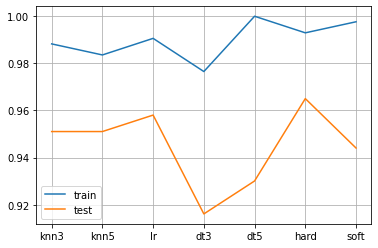

In [18]:
import matplotlib.pyplot as plt
temp.plot()
plt.grid(True)
plt.show()

In [ ]:
# # [3] 각 모델을 make_classification_model 을 사용하여 학습 
# Tnames = ['hard', 'soft'] + names
# Testimators = [hard, soft] + estimator

# # 반복문을 사용한 ensemble 및 단독 모델 성능 비교
# result = []
# for a, b in zip(Tnames, Testimators):
#     r = make_classification_model(a, b, data_cancer)
#     #display(r)
#     result.append(r)
    
# df = pd.concat(result, ignore_index=True)
# df

In [ ]:
# [4] accuracy1, accuracy2, diff 구하기
df['diff'] = 

temp = df[['name', 'accuracy1', 'accuracy2', 'diff']]
# temp를 diff를 기준으로 오름차순 정렬


,name,accuracy1,accuracy2,diff
3,knn5,0.9836,0.951,0.0247
4,lr,0.9906,0.958,0.0258
0,hard,0.993,0.958,0.027
2,knn3,0.9883,0.951,0.0285
1,soft,0.9977,0.9441,0.0421
5,dt3,0.9765,0.9161,0.0487
6,dt5,1.0,0.9021,0.0795


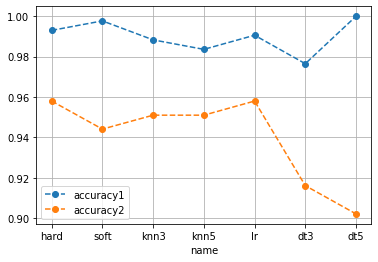

In [ ]:
# [5] accuracy 에 대한 선 그래프 그리기
import matplotlib.pyplot as plt

plt.grid()
plt.show()

### 2-3) 배깅(Bagging) 방식 - RandomForest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [27]:
from sklearn.ensemble import RandomForestClassifier
# [6] cancer 데이터, RandomForestClassifier를 사용하여 학습하고 성능을 확인한다
# RandomForestClassifier의 경우 max_depth=4, random_state=0 사용
model = RandomForestClassifier(100, max_depth=3, random_state=0)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9882629107981221, 0.9440559440559441)

### 2-4) 부스팅(Boosting) 방식 : GradientBoosting

In [32]:
GradientBoostingClassifier?
    *,
    loss='log_loss',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
    
    # test_size=0.2, random_state=121  (train_test_splilt에서)

In [42]:
# [7] cancer 데이터, GradientBoostingClassifier를 사용하여 학습하고 성능을 확인한다
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=0.2, 
                                   subsample=0.6, 
                                   n_estimators=100, random_state=0)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.958041958041958)

### 2-5) Stacking 방식 : StackingClassifier

In [43]:
from sklearn.ensemble import StackingClassifier
StackingClassifier?

In [44]:
from sklearn.ensemble import StackingClassifier

# [8] RandomForestClassifier, GradientBoostingClassifier 를 estimators로 사용하고
# LogisticRegression을 final_estimator로 사용한다
# 이때, estimator 각각에 이름은 'rf', 'gb'로 사용한다
name = ['rf', 'gb']
estimator = [RandomForestClassifier(), GradientBoostingClassifier()]
estimators = list(zip(name, estimator))

model = StackingClassifier(estimators, LogisticRegression())
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.958041958041958)

### 2-6) XGBOOST(Extream Gradient Boost)

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### XGBOOST 분류
- https://xgboost.readthedocs.io/en/latest/index.html
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [56]:
from xgboost import XGBClassifier
XGBClassifier?

In [57]:
from xgboost import XGBClassifier

# [9] XGBClassifier 를 사용하여 model을 만들고 학습시킨 뒤 성능을 확인한다
#   n_estimators=400, learning_rate=0.1, max_depth=3, 
#   use_label_encoder=False (Deprecated) eval_metric='logloss' 을 사용한다
model = XGBClassifier(n_estimators=400, learning_rate=0.2, max_depth=3, eval_metric='logloss', random_state=0)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.965034965034965)

- https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost

#### XGBOOST 회귀 

In [71]:
boston = pd.read_csv('data_05/boston.csv')
boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

In [75]:
from xgboost import XGBRegressor
import pandas as pd

# [10] 보스톤 데이터 준비, 데이터 분리하여 data_boston 생성
boston = pd.read_csv('data_05/boston.csv')
X = boston.drop(columns='PRICE')
Y = boston['PRICE']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
A = train_test_split(X_scaled, Y, test_size=0.25, random_state=0)
x_train, x_test, y_train, y_test = A
print([x.shape for x in A])

# [11] XGBRegressor 를 사용하여 model을 만들고 학습시킨 뒤 성능을 확인한다
#   다음 값을 사용한다
#   n_estimators=1000, learning_rate=0.2, max_depth=3,
#   objective ='reg:squarederror'
model = XGBRegressor(n_estimators=1000, learning_rate=0.4, max_depth=3, objective ='reg:squarederror')
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

[(379, 13), (127, 13), (379,), (127,)]


(0.9999999683587407, 0.758384747432559)

### 2-7) lightGBM

In [ ]:
!pip install lightgbm

#### ligthGBM  분류
- https://lightgbm.readthedocs.io/en/latest/
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

In [68]:
LGBMClassifier?

In [70]:
from lightgbm import LGBMClassifier
# [12] data_cancer, LGBMClassifier를 사용하여 학습 후 성능 출력
# n_estimators=100으로 사용한다 (여러 가지로 변경해 볼 것)
model = LGBMClassifier(n_estimators=500, min_data_in_leaf=40, feature_fraction=0.6, reg_lambda=0.1)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


(1.0, 0.958041958041958)

#### ligthGBM  회귀
- https://nicola-ml.tistory.com/51

In [79]:
from lightgbm import LGBMRegressor

boston = pd.read_csv('data_05/boston.csv')
X = boston.drop(columns='PRICE')
Y = boston['PRICE']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
A = train_test_split(X_scaled, Y, test_size=0.25, random_state=0)
x_train, x_test, y_train, y_test = A
print([x.shape for x in A])

# n_estimators=100로 사용한다 (여러 가지로 변경해 볼 것, 개수, max_depth)
model = LGBMRegressor(n_estimators=1000, max_depth=3)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

[(379, 13), (127, 13), (379,), (127,)]


(0.9976126018855925, 0.7713717904317868)

In [ ]:
# GridSearchCV를 사용한 hyper parameter 최적화 (ML_01에서 학습)

In [ ]:
# 3개
#n_estimators= 100, 200, 300, 500, 1000  (5가지)
#leaning_rate = 0.01, 0.05, 0.1, 1, 10 (5가지)
#max_depth = 3, 4, 5, 6 (4가지)
#5 * 5 * 4 만큼 실행해야 가장 좋은 hyper parameter를 찾을 수 있음

In [ ]:
# GridSearch -> 모든 조합에 대해 실행해봄
# CV (CrossValidataion) = 5, shuffle=False